# <span style="color:#84b6f4;">Detección de emociones (tristeza)</span>

### <span style="color:#77dd77;">Conjuntos de datos de entrenamiento y prueba</span>

En este ejemplo, trataremos de clasificar imágenes, dependiendo de si el rostro que se muestra en ellas transmite o no tristeza. Para ello, utilizaremos conjuntos de datos de entrenamiento y prueba ya existentes, con rostros etiquetados para diferentes emociones:

In [18]:
import pandas as pd

df = pd.read_csv('resources/fer2013.csv')

# Filtrar solo las filas necesarias para entrenamiento y prueba
train_df = df[df['Usage'] == 'Training']
test_df = df[df['Usage'] == 'PublicTest']

# Verificar si las filas se filtraron correctamente
print(f"Training samples: {len(train_df)}, Test samples: {len(test_df)}")

Training samples: 28709, Test samples: 3589


Convertimos el problema a uno de clasificación binaria, centrándonos únicamente en la detección de imágenes tristes:

In [19]:
import numpy as np

# Función para procesar los datos
def process_data(dataframe, index):
    # Convertir los pixeles a una matriz numpy
    X = np.array([np.fromstring(pixels, sep=' ') for pixels in dataframe['pixels']])
    X = X.reshape(-1, 48, 48, 1)  # Reformatear en imágenes
    y = dataframe['emotion'].values
    y_binary = (y == index).astype(int)  # 1 si 'Tristeza', 0 si no
    return X, y_binary

SAD_INDEX = 4

# Procesar los conjuntos de entrenamiento y prueba
X_train, y_train = process_data(train_df, SAD_INDEX)
X_test, y_test = process_data(test_df, SAD_INDEX)

# Normalizar las imágenes
X_train = X_train / 255.0
X_test = X_test / 255.0

### <span style="color:#77dd77;">Balanceo de clases</span>

En el conjunto de entrenamiento hay un desbalance bastante notorio, por lo que debemos limitar la clase sobrerrepresentada y generar nuevas muestras de la clase subrepresentada para llegar a ese límite:

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Función para limitar la clase sobrerrepresentada a un número máximo de muestras
def limit_class(X, y, target_class, max_samples):
    mask = (y == target_class)
    indices = np.where(mask)[0]
    if len(indices) > max_samples:
        indices = np.random.choice(indices, max_samples, replace=False)
    else:
        return X[indices], y[indices]  # No limitar si hay menos muestras que max_samples
    limited_X = X[indices]
    limited_y = y[indices]
    return limited_X, limited_y

# Limitar la clase "Not Sad" a 4000 muestras
X_train_not_sad, y_train_not_sad = limit_class(X_train, y_train, 0, 4000)

# Limitar la clase "Sad" a 5000 muestras
X_train_sad, y_train_sad = limit_class(X_train, y_train, 1, 4000)

# Combinar ambas clases
X_train_balanced = np.concatenate((X_train_not_sad, X_train_sad), axis=0)
y_train_balanced = np.concatenate((y_train_not_sad, y_train_sad), axis=0)

# Mezclar el conjunto balanceado
indices = np.random.permutation(len(X_train_balanced))
X_train_balanced = X_train_balanced[indices]
y_train_balanced = y_train_balanced[indices]

# Verificar el nuevo balance en el conjunto de entrenamiento
unique_balanced, counts_balanced = np.unique(y_train_balanced, return_counts=True)
print("\nConteo de etiquetas en el conjunto de entrenamiento balanceado:")
for label, count in zip(unique_balanced, counts_balanced):
    print(f"Tristeza: {label}, Cantidad: {count}")


Conteo de etiquetas en el conjunto de entrenamiento balanceado:
Tristeza: 0, Cantidad: 4000
Tristeza: 1, Cantidad: 4000


Aplicamos técnicas de aumento de datos para duplicar la cantidad de muestras de ambas clases:

In [21]:
# Crear un generador de datos de imagen para aumentar los datos
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Función para aumentar las imágenes de una clase específica
def augment_images(X, y, datagen, augment_factor):
    augmented_images = []
    augmented_labels = []
    for i in range(len(X)):
        for _ in range(augment_factor):
            augmented_image = next(datagen.flow(X[i:i+1], batch_size=1))[0]
            augmented_images.append(augmented_image)
            augmented_labels.append(y[i])
    return np.array(augmented_images), np.array(augmented_labels)

# Aumentar las imágenes de la clase "Not Sad" al doble
X_train_not_sad_augmented, y_train_not_sad_augmented = augment_images(X_train_not_sad, y_train_not_sad, datagen, 1)

# Aumentar las imágenes de la clase "Sad" al doble
X_train_sad_augmented, y_train_sad_augmented = augment_images(X_train_sad, y_train_sad, datagen, 1)

# Combinar las imágenes originales y aumentadas en el conjunto de entrenamiento
X_train_balanced = np.concatenate((X_train_not_sad, X_train_sad, X_train_not_sad_augmented, X_train_sad_augmented), axis=0)
y_train_balanced = np.concatenate((y_train_not_sad, y_train_sad, y_train_not_sad_augmented, y_train_sad_augmented), axis=0)

# Mezclar el conjunto balanceado de entrenamiento
indices_train = np.random.permutation(len(X_train_balanced))
X_train_balanced = X_train_balanced[indices_train]
y_train_balanced = y_train_balanced[indices_train]

# Verificar el nuevo balance en el conjunto de entrenamiento
unique_balanced_train, counts_balanced_train = np.unique(y_train_balanced, return_counts=True)
print("\nConteo de etiquetas en el conjunto de entrenamiento balanceado y aumentado:")
for label, count in zip(unique_balanced_train, counts_balanced_train):
    print(f"Tristeza: {label}, Cantidad: {count}")


Conteo de etiquetas en el conjunto de entrenamiento balanceado y aumentado:
Tristeza: 0, Cantidad: 8000
Tristeza: 1, Cantidad: 8000


Mostramos ejemplos positivos y negativos para comprobar si el proceso se ha hecho correctamente:

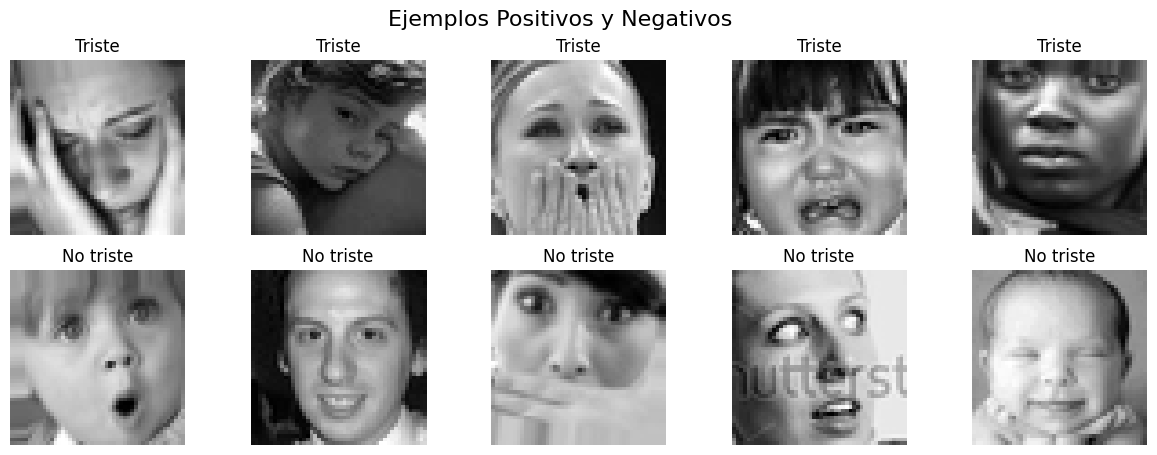

In [22]:
import random
import matplotlib.pyplot as plt

# Función para mostrar ejemplos visuales
def show_examples(X, y, num_pos=5, num_neg=5):
    pos_indices = np.where(y == 1)[0]
    neg_indices = np.where(y == 0)[0]

    fig, axes = plt.subplots(2, max(num_pos, num_neg), figsize=(15, 5))
    fig.suptitle("Ejemplos Positivos y Negativos", fontsize=16)

    for i, idx in enumerate(random.sample(list(pos_indices), num_pos)):
        axes[0, i].imshow(X[idx].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title("Triste")

    for i, idx in enumerate(random.sample(list(neg_indices), num_neg)):
        axes[1, i].imshow(X[idx].squeeze(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("No triste")

    plt.show()

# Mostrar 5 ejemplos positivos y 5 negativos para comprobar la separación
show_examples(X_train_balanced, y_train_balanced, num_pos=5, num_neg=5)

Hacemos lo mismo con el conjunto de prueba, que también está desbalanceado:

In [23]:
# Limitar la clase "Not Sad" a 500 muestras en el conjunto de pruebas
X_test_not_sad, y_test_not_sad = limit_class(X_test, y_test, 0, 500)

# Limitar la clase "Sad" a 500 muestras en el conjunto de pruebas
X_test_sad, y_test_sad = limit_class(X_test, y_test, 1, 500)

# Combinar ambas clases en el conjunto de pruebas
X_test_balanced = np.concatenate((X_test_not_sad, X_test_sad), axis=0)
y_test_balanced = np.concatenate((y_test_not_sad, y_test_sad), axis=0)

# Mezclar el conjunto balanceado de pruebas
indices_test = np.random.permutation(len(X_test_balanced))
X_test_balanced = X_test_balanced[indices_test]
y_test_balanced = y_test_balanced[indices_test]

# Verificar el nuevo balance en el conjunto de pruebas
unique_balanced_test, counts_balanced_test = np.unique(y_test_balanced, return_counts=True)
print("\nConteo de etiquetas en el conjunto de pruebas balanceado:")
for label, count in zip(unique_balanced_test, counts_balanced_test):
    print(f"Enfado: {label}, Cantidad: {count}")


Conteo de etiquetas en el conjunto de pruebas balanceado:
Enfado: 0, Cantidad: 500
Enfado: 1, Cantidad: 500


### <span style="color:#77dd77;">Entrenamiento</span>

Creamos un modelo de red neuronal convolucional (CNN) y lo entrenamos:

Epoch 1/30
500/500 [==============================] - 24s 47ms/step - loss: 1.7359 - accuracy: 0.5590 - val_loss: 0.9526 - val_accuracy: 0.5820 - lr: 0.0010
Epoch 2/30
500/500 [==============================] - 23s 46ms/step - loss: 0.8127 - accuracy: 0.5747 - val_loss: 0.7198 - val_accuracy: 0.6270 - lr: 0.0010
Epoch 3/30
500/500 [==============================] - 23s 45ms/step - loss: 0.7321 - accuracy: 0.5969 - val_loss: 0.7505 - val_accuracy: 0.6180 - lr: 0.0010
Epoch 4/30
500/500 [==============================] - 23s 46ms/step - loss: 0.7187 - accuracy: 0.6124 - val_loss: 0.6917 - val_accuracy: 0.6460 - lr: 0.0010
Epoch 5/30
500/500 [==============================] - 23s 46ms/step - loss: 0.7017 - accuracy: 0.6313 - val_loss: 0.6748 - val_accuracy: 0.6570 - lr: 0.0010
Epoch 6/30
500/500 [==============================] - 23s 46ms/step - loss: 0.6914 - accuracy: 0.6478 - val_loss: 0.6903 - val_accuracy: 0.6430 - lr: 0.0010
Epoch 7/30
500/500 [==============================] - 23s 

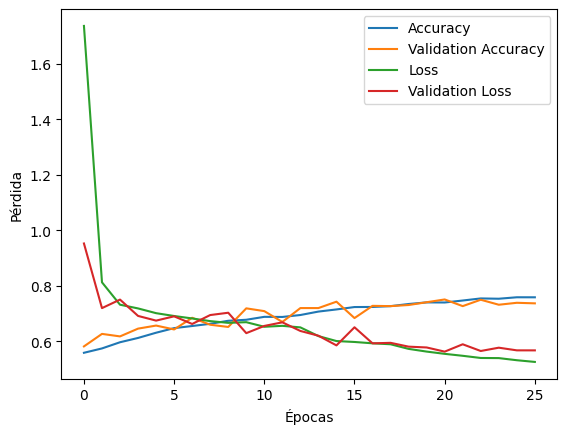

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Definir el modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Definir las devoluciones de llamada
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Entrenar el modelo
history = model.fit(
    x=X_train_balanced,
    y=y_train_balanced,
    validation_data=(X_test_balanced, y_test_balanced),
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# Mostrar los resultados del entrenamiento
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

### <span style="color:#77dd77;">Evaluación</span>

Evaluamos los resultados del modelo, utilizando métricas como la precisión, el F1-score y la matriz de confusión:

32/32 [==============================] - 0s 11ms/step

Reporte de Clasificación:
               precision    recall  f1-score   support

     Not Sad       0.78      0.69      0.74       500
         Sad       0.73      0.81      0.76       500

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.75      0.75      0.75      1000



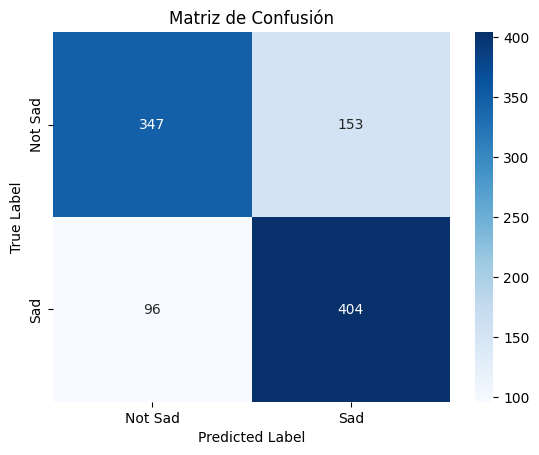

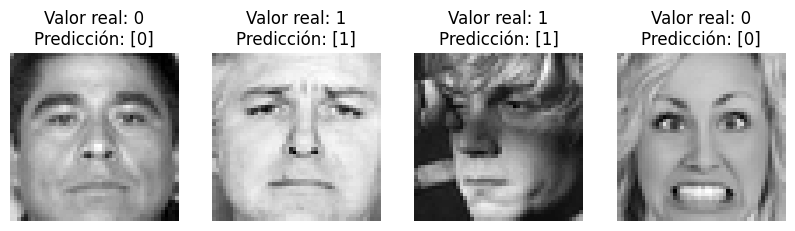

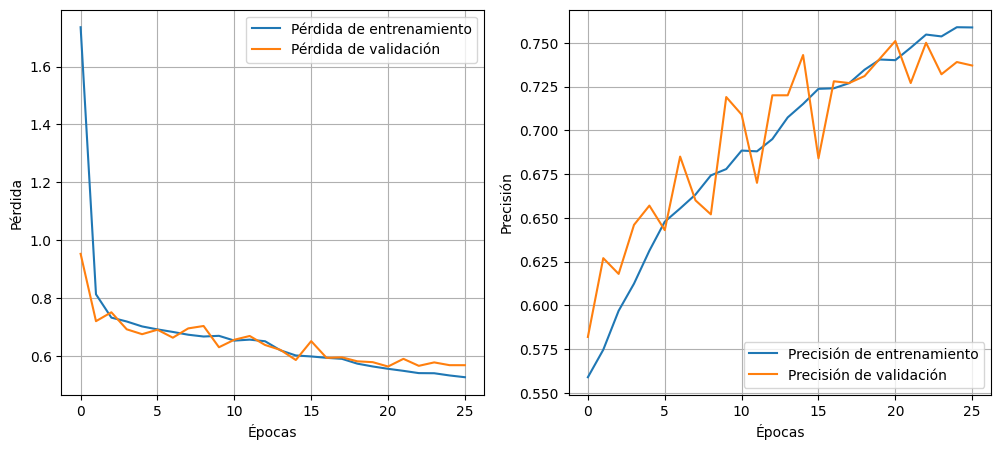

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Evaluación del modelo
y_pred = (model.predict(X_test_balanced) > 0.5).astype(int)

# Generar el reporte de clasificación y la matriz de confusión
report = classification_report(y_test_balanced, y_pred, target_names=['Not Sad', 'Sad'])
print("\nReporte de Clasificación:\n", report)

# Crear y visualizar la matriz de confusión
cm = confusion_matrix(y_test_balanced, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sad', 'Sad'], yticklabels=['Not Sad', 'Sad'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusión')
plt.show()

# Mostrar 4 ejemplos del conjunto de pruebas con sus predicciones
def show_evaluated_examples(X, y_true, y_pred, num_examples=4):
    indices = random.sample(range(len(X)), num_examples)
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_examples, i+1)
        plt.imshow(X[idx].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Valor real: {y_true[idx]}\nPredicción: {y_pred[idx]}')
    plt.show()

show_evaluated_examples(X_test_balanced, y_test_balanced, y_pred, num_examples=4)

# Gráfico del progreso de entrenamiento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.show()

Para finalizar, exportamos el modelo:

In [26]:
from joblib import dump

# Guardamos el modelo
model_filename = 'sad_detection.joblib'
dump(model, model_filename)

['sad_detection.joblib']